In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/pickle/Final_result_list(basic).pkl','rb') as f:
  Final_result_list_basic = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/pickle/Final_result_list(Per).pkl','rb') as f:
  Final_result_list_per = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/pickle/Final_result_list(each_2).pkl','rb') as f:
  Final_result_list_each = pickle.load(f)

In [3]:
len(Final_result_list_basic)

10000

In [4]:
len(Final_result_list_per)

10000

In [5]:
len(Final_result_list_each)

10000

In [ ]:
Final_result_list_basic[1][0]

In [ ]:
Final_result_list_each[0][0]

In [ ]:
Final_result_list_per[0][0]

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/Final_result_list.pkl','rb') as f:
#  Final_result_list= pickle.load(f)

In [ ]:
#import pickle
#with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/X_train.pkl','rb') as f:
#  X_train = pickle.load(f)

### FastText 불러오기

In [ ]:
!pip install --upgrade gensim==3.8.0

In [7]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('/content/drive/MyDrive/Colab Notebooks/FastText_pretrained/cc.ko.300.bin')

In [8]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

#### 태그를 대표어로 replace

In [9]:
import pandas as pd
tag_represent = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AURA2/data/태깅DICT.CSV', encoding='cp949')
tag_represent.head()

,PS_NAME,인물이름
0,PS_CHARACTER,캐릭터이름
1,PS_PET,반려동물이름
2,FD_SCIENCE,과학
3,FD_SOCIAL_SCIENCE,사회과학
4,FD_MEDICINE,의학


In [10]:
tag_to_represent = {'PS_NAME' : '인물이름'}
for i in range(1, len(tag_represent)) :
  if str(tag_represent.loc[i, 'PS_NAME']) == "TM_SELL_TISSUE_ORGAN" :
    tag_to_represent["TM_CELL_TISSUE_ORGAN"] = str(tag_represent.loc[i, '인물이름'])
    continue
  tag_to_represent[str(tag_represent.loc[i, 'PS_NAME'])] = str(tag_represent.loc[i, '인물이름'])

In [11]:
len(tag_represent) == len(tag_to_represent)

True

#### 문장의 임베딩 평균을 이용한 유사도

In [12]:
# ner사용하지 않고, 단순히 문장 간 유사도 비교
def fasttext_sim(convrs, model, tag_to_represent) : # model : FastText model
  cos_sim_lst = []
  sentences = []
  
  ners = []
  for i in range(0, len(convrs[0]), 2) :
    if len(convrs[0]) % 2 == 0 : # 개수가 짝수
      sent1 = convrs[0][i]
      ner1 = convrs[1][i]
      sent2 = convrs[0][i+1]
      ner2 = convrs[1][i+1]
      sentences.append(sent1)
      sentences.append(sent2)
      ners.append(ner1)
      ners.append(ner2)
    else :
      if i == len(convrs[0])-1 :
        sentences.append(convrs[0][i])
        ners.append(convrs[1][i])
        break
      else :
        sent1 = convrs[0][i]
        ner1 = convrs[1][i]
        sent2 = convrs[0][i+1]
        ner2 = convrs[1][i+1]
        sentences.append(sent1)
        sentences.append(sent2)
        ners.append(ner1)
        ners.append(ner2)

  #print(sentences)
  og_sentences = sentences[:]
  tmp_sent_len = [len(s) for s in sentences]
  tmp_ner_len = [len(t) for t in ners]
  #print(tmp_sent_len, tmp_ner_len)
  
  
  # ner 태그를 sent에 replace하기
  for i in range(len(sentences)) :
    #print(sentences[i])
    #print(ners[i])
    for j in range(len(sentences[i])) :
      if len(ners[i]) < len(sentences[i]) and j == len(ners[i]) -1 :
        break
      if ners[i][j] == 'PAD' :
        break
      elif ners[i][j] == 'O' :
        continue
      else :
        sentences[i][j] = ners[i][j]
  
  # B-AFA_DOCUMENT I-AFA_DOCUMENT -> 합친 후 AFA_DOCUMENT로 통일
  tmp_sentences = []
  #print("og", sentences)
  for i in range(len(sentences)) :
    tmp_sentence = []
    tmp_ner = ''
    for j in range(len(sentences[i])) :
      if len(sentences[i][j]) == 0 :
        continue
      #if sentences[i][j].isalpha() :
        #print("HO")
      #print(sentences[i][j])
      if sentences[i][j][:2] == 'B-' :
        if j == len(sentences[i]) - 1 :# 마지막
          tmp_sentence.append(sentences[i][j][2:])
          tmp_ner = ''
          continue
        elif j != len(sentences[i]) - 1 and sentences[i][j+1][:2] != 'I-' :
          tmp_sentence.append(sentences[i][j][2:])
          tmp_ner = ''
          continue
        else :
          tmp_ner = sentences[i][j][2:]
          continue
      if j == len(sentences[i]) - 1 :
        if sentences[i][j][:2] == 'I-' :
          tmp_sentence.append(sentences[i][j][2:])
      elif sentences[i][j][:2] == 'I-' and sentences[i][j][2:] == tmp_ner and sentences[i][j+1][2:] == tmp_ner :
        #print("hello")
        continue
      elif sentences[i][j][:2] == 'I-' and sentences[i][j][2:] == tmp_ner and sentences[i][j+1][2:] != tmp_ner :
        #print("hi")
        tmp_sentence.append(tmp_ner)
      else :
        tmp_sentence.append(sentences[i][j])
    tmp_sentences.append(tmp_sentence)
  sentences_ = tmp_sentences[:]
  #print("after", sentences_) # 태그가 sentence에 안들어가는 문제 발생
  #new_sentences = [' '.join(s) for s in sentences_]
  #print(new_sentences)
  #print(sentences_)
  
  # tag to represent
  for i in range(len(sentences_)) :
    for j in range(len(sentences_[i])) :
      if sentences_[i][j] in tag_to_represent :
        sentences_[i][j] = tag_to_represent[sentences_[i][j]]
  #print(sentences_)

  # 유사도 계산
  sentences_embedding = []
  for i in range(len(sentences_)) :
    tmp = 0
    for j in range(len(sentences_[i])) :
      #print(model[sentences_[i][j]])
      #if np.isnan(model[sentences[i][j]]) :
      #  continue
      #else : 
      tmp += model[sentences_[i][j]]
    if len(sentences_[i]) == 0 :
      return [0], 0
    sentences_embedding.append(tmp / len(sentences_[i])) # 단어 임베딩들을 모두 합한 후 평균낸다.
  #print(sentences_embedding)
  
  # sentences간 cos_sim 구하기
  for i in range(len(sentences_embedding) - 1) :
    #print(sentences_embedding[i+1])
    cos_sim_lst.append(cos_sim(sentences_embedding[i], sentences_embedding[i+1]))
  if len(cos_sim_lst) == 0 :
    return [0], 0
  return cos_sim_lst, sum(cos_sim_lst)/len(cos_sim_lst)
  

In [ ]:
# test
fasttext_sim(Final_result_list_basic[1], ko_model, tag_to_represent)

<ipython-input-16-e0a2902436c9>:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tmp += model[sentences_[i][j]]


([0.5951324,
  0.7393522,
  0.7004225,
  0.7064613,
  0.81000125,
  0.8023386,
  0.7255267,
  0.6067309,
  0.60098904,
  0.65749264,
  0.45360628,
  0.5265741,
  0.53257966],
 0.6505544300262744)

In [ ]:

convrs_sim_avg = []
convrs_sim_basic = []
convrs_sim_per = []
convrs_sim_each = []

for i in range(len(Final_result_list_basic)) :
  ft_sim = fasttext_sim(Final_result_list_basic[i], ko_model, tag_to_represent)[1]
  convrs_sim_basic.append(ft_sim)

for i in range(len(Final_result_list_each)) :
  ft_sim = fasttext_sim(Final_result_list_each[i], ko_model, tag_to_represent)[1]
  convrs_sim_each.append(ft_sim)

for i in range(len(Final_result_list_per)) :
  ft_sim = fasttext_sim(Final_result_list_per[i], ko_model, tag_to_represent)[1]
  convrs_sim_per.append(ft_sim)
  

In [14]:
len(convrs_sim_basic), len(convrs_sim_per), len(convrs_sim_each)

(10000, 10000, 10000)

In [15]:
import pickle
with open('convrs_sim_basic.pkl','wb') as f:
  pickle.dump(convrs_sim_basic,f)

with open('convrs_sim_each.pkl','wb') as f:
  pickle.dump(convrs_sim_each,f)

with open('convrs_sim_per.pkl','wb') as f:
  pickle.dump(convrs_sim_per,f)

In [16]:
convrs_sim_avg = [(convrs_sim_basic[i] + convrs_sim_each[i] + convrs_sim_per[i]) / 3 for i in range(len(convrs_sim_basic))]
len(convrs_sim_avg)

10000

In [ ]:
convrs_sim_tuple = []
for i in range(len(convrs_sim_avg)) :
  convrs_sim_tuple.append((convrs_sim_avg[i], i))
convrs_sim_tuple

In [18]:
convrs_sim_tuple_asc = sorted(convrs_sim_tuple, key = lambda x : x[0])
convrs_sim_tuple_asc[:-5:-1]

[(0.8987034024614275, 4867),
 (0.8693898968207531, 7717),
 (0.8682966050776568, 7133),
 (0.8646937932214166, 7278)]

In [19]:
# Final_result_list_basic 바껴있어서 피클로 다시한번 불러와야함
with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/pickle/Final_result_list(basic).pkl','rb') as f:
  Final_result_list_basic = pickle.load(f)

(array([  16.,   32.,  239.,  626., 1497., 1330., 1742., 2793., 1546.,
         117.]),
 array([0.        , 0.08987034, 0.17974068, 0.26961102, 0.35948136,
        0.4493517 , 0.53922204, 0.62909238, 0.71896272, 0.80883306,
        0.8987034 ]),
 <a list of 10 Patch objects>)

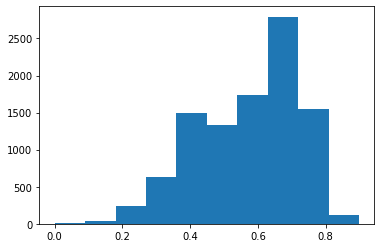

In [20]:
import matplotlib.pyplot as plt
plt.hist([c[0] for c in convrs_sim_tuple_asc])

In [21]:
def min_max_scaler(lst) :
  min_ = min([t[0] for t in lst])
  max_ = max([t[0] for t in lst])
  result = []
  for i in range(len(lst)) :
    tmp = (lst[i][0]-min_)/(max_-min_)
    result.append((tmp, lst[i][1]))
  return result

In [22]:
convrs_sim_tuple_asc_scale = min_max_scaler(convrs_sim_tuple_asc)
len(convrs_sim_tuple_asc_scale)

10000

(array([  16.,   32.,  239.,  626., 1497., 1330., 1742., 2793., 1546.,
         117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

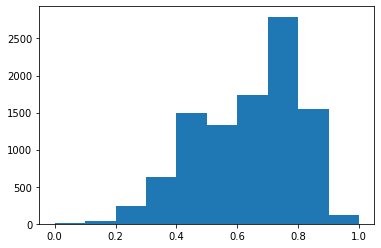

In [23]:
import matplotlib.pyplot as plt
plt.hist([c[0] for c in convrs_sim_tuple_asc_scale])

In [ ]:
tmp = [t for t in convrs_sim_tuple_asc_scale if t[0] > 0.9 and t[0] <= 1.0]
tmp = sorted(tmp, key = lambda x : x[0])
tmp

In [ ]:
Final_result_list_basic[6298][0]

In [36]:
# ner사용하지 않고, 단순히 문장 간 유사도 비교
def fasttext_sim_no_replace(convrs, model, tag_to_represent) : # model : FastText model
  cos_sim_lst = []
  sentences = []
  
  ners = []
  for i in range(0, len(convrs[0]), 2) :
    if len(convrs[0]) % 2 == 0 : # 개수가 짝수
      sent1 = convrs[0][i]
      ner1 = convrs[1][i]
      sent2 = convrs[0][i+1]
      ner2 = convrs[1][i+1]
      sentences.append(sent1)
      sentences.append(sent2)
      ners.append(ner1)
      ners.append(ner2)
    else :
      if i == len(convrs[0])-1 :
        sentences.append(convrs[0][i])
        ners.append(convrs[1][i])
        break
      else :
        sent1 = convrs[0][i]
        ner1 = convrs[1][i]
        sent2 = convrs[0][i+1]
        ner2 = convrs[1][i+1]
        sentences.append(sent1)
        sentences.append(sent2)
        ners.append(ner1)
        ners.append(ner2)

  #print(sentences)
  og_sentences = sentences[:]
  #print(og_sentences)
  tmp_sent_len = [len(s) for s in sentences]
  tmp_ner_len = [len(t) for t in ners]
  #print(tmp_sent_len, tmp_ner_len)
  
  """
  # ner 태그를 sent에 replace하기
  for i in range(len(sentences)) :
    #print(sentences[i])
    #print(ners[i])
    for j in range(len(sentences[i])) :
      if len(ners[i]) < len(sentences[i]) and j == len(ners[i]) -1 :
        break
      if ners[i][j] == 'PAD' :
        break
      elif ners[i][j] == 'O' :
        continue
      else :
        sentences[i][j] = ners[i][j]
  
  # B-AFA_DOCUMENT I-AFA_DOCUMENT -> 합친 후 AFA_DOCUMENT로 통일
  tmp_sentences = []
  #print("og", sentences)
  for i in range(len(sentences)) :
    tmp_sentence = []
    tmp_ner = ''
    for j in range(len(sentences[i])) :
      if len(sentences[i][j]) == 0 :
        continue
      #if sentences[i][j].isalpha() :
        #print("HO")
      #print(sentences[i][j])
      if sentences[i][j][:2] == 'B-' :
        if j == len(sentences[i]) - 1 :# 마지막
          tmp_sentence.append(sentences[i][j][2:])
          tmp_ner = ''
          continue
        elif j != len(sentences[i]) - 1 and sentences[i][j+1][:2] != 'I-' :
          tmp_sentence.append(sentences[i][j][2:])
          tmp_ner = ''
          continue
        else :
          tmp_ner = sentences[i][j][2:]
          continue
      if j == len(sentences[i]) - 1 :
        if sentences[i][j][:2] == 'I-' :
          tmp_sentence.append(sentences[i][j][2:])
      elif sentences[i][j][:2] == 'I-' and sentences[i][j][2:] == tmp_ner and sentences[i][j+1][2:] == tmp_ner :
        #print("hello")
        continue
      elif sentences[i][j][:2] == 'I-' and sentences[i][j][2:] == tmp_ner and sentences[i][j+1][2:] != tmp_ner :
        #print("hi")
        tmp_sentence.append(tmp_ner)
      else :
        tmp_sentence.append(sentences[i][j])
    tmp_sentences.append(tmp_sentence)
  sentences_ = tmp_sentences[:]
  #print("after", sentences_) # 태그가 sentence에 안들어가는 문제 발생
  #new_sentences = [' '.join(s) for s in sentences_]
  #print(new_sentences)
  #print(sentences_)
  
  # tag to represent
  for i in range(len(sentences_)) :
    for j in range(len(sentences_[i])) :
      if sentences_[i][j] in tag_to_represent :
        sentences_[i][j] = tag_to_represent[sentences_[i][j]]
  #print(sentences_)
"""
  # 유사도 계산
  sentences_ = og_sentences
  sentences_embedding = []
  for i in range(len(sentences_)) :
    tmp = 0
    for j in range(len(sentences_[i])) :
      #print(model[sentences_[i][j]])
      #if np.isnan(model[sentences[i][j]]) :
      #  continue
      #else : 
      tmp += model[sentences_[i][j]]
    if len(sentences_[i]) == 0 :
      return [0], 0
    sentences_embedding.append(tmp / len(sentences_[i])) # 단어 임베딩들을 모두 합한 후 평균낸다.
  #print(sentences_embedding)
  
  # sentences간 cos_sim 구하기
  for i in range(len(sentences_embedding) - 1) :
    #print(sentences_embedding[i+1])
    cos_sim_lst.append(cos_sim(sentences_embedding[i], sentences_embedding[i+1]))
  if len(cos_sim_lst) == 0 :
    return [0], 0
  return cos_sim_lst, sum(cos_sim_lst)/len(cos_sim_lst)
  

In [ ]:
convrs_sim_no_replace = []
for i in range(len(Final_result_list_basic)) :
  ft_sim = fasttext_sim_no_replace(Final_result_list_basic[i], ko_model, tag_to_represent)[1]
  convrs_sim_no_replace.append(ft_sim)

In [39]:
convrs_sim_no_replace[0]

0.5476956936446103

In [ ]:
convrs_sim_tuple_no_replace = []
for i in range(len(convrs_sim_no_replace)) :
  convrs_sim_tuple_no_replace.append((convrs_sim_no_replace[i], i))
convrs_sim_tuple_no_replace

In [41]:
convrs_sim_tuple_asc_no_replace = sorted(convrs_sim_tuple_no_replace, key = lambda x : x[0])
convrs_sim_tuple_asc_no_replace[:-5:-1]

[(0.7977182428042094, 2943),
 (0.7846527587283741, 9897),
 (0.7752113405026888, 8938),
 (0.7696661082181063, 8913)]

In [45]:
convrs_sim_tuple_asc[:-5:-1]

[(0.8987034024614275, 4867),
 (0.8693898968207531, 7717),
 (0.8682966050776568, 7133),
 (0.8646937932214166, 7278)]

In [43]:
# Final_result_list_basic 바껴있어서 피클로 다시한번 불러와야함
with open('/content/drive/MyDrive/Colab Notebooks/AURA2/data/pickle/Final_result_list(basic).pkl','rb') as f:
  Final_result_list_basic = pickle.load(f)

In [46]:
Final_result_list_basic[4867][0]

[['안녕', '하세요!', '학생', '이신가요?'],
 ['안녕',
  '하세요',
  '학생',
  '은',
  '아니지만',
  '학창시절',
  '기억',
  '은',
  '있어요',
  '지금',
  '드는',
  '생각',
  '은',
  '급식',
  '이',
  '진짜',
  '좋은',
  '거였구나',
  '하는',
  '생각',
  '이에요',
  '성인',
  '되고',
  '영양',
  '챙겨',
  '먹으려니',
  '은근',
  '번거',
  '롭더라고요'],
 ['저도',
  '그렇게',
  '생각',
  '해요!',
  '학교',
  '다닐',
  '때는',
  '몰랐는데',
  '영양요소',
  '다',
  '챙긴',
  '급식',
  '이',
  '그립더라고요',
  '매일',
  '뭐',
  '먹을지',
  '고민',
  '안',
  '해도',
  '되고',
  '그렇지만',
  '과제',
  '나',
  '시험',
  '은',
  '그립지',
  '않네요'],
 ['맞아요',
  '과',
  '제랑',
  '시험',
  '은',
  '절레절레',
  '아침',
  '일찍',
  '일어',
  '나서',
  '준비',
  '하는',
  '것도',
  '은근',
  '빡셌던',
  '것',
  '같아요',
  '머리',
  '긴',
  '친구',
  '들은',
  '겨울',
  '에',
  '머리',
  '감고',
  '안',
  '말리고',
  '등교',
  '하면',
  '머리카락',
  '이',
  '얼어서',
  '바삭바삭',
  '해졌었는데',
  '서로',
  '너',
  '머리카락',
  '고드름',
  '됐다면서',
  '깔깔',
  '웃고',
  '했던',
  '기억',
  '이',
  '나요',
  '여름',
  '때면',
  '창밖',
  '으로',
  '매미',
  '우는소리랑',
  '체육시간',
  '인',
  '애들',
  '이',
  '떠드는',
  '소리',
  '가',
  '들려오던',
  '것

(array([ 571.,    3.,   84.,  345.,  889., 1886., 2880., 2378.,  734.,
          48.]),
 array([0.        , 0.08643017, 0.17286033, 0.2592905 , 0.34572067,
        0.43215083, 0.518581  , 0.60501117, 0.69144133, 0.7778715 ,
        0.86430167]),
 <a list of 10 Patch objects>)

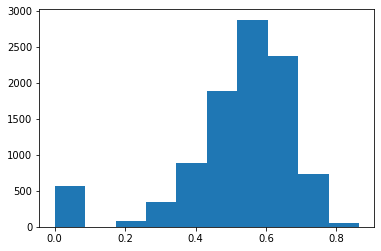

In [42]:
import matplotlib.pyplot as plt
plt.hist([c[0] for c in convrs_sim_tuple_asc_no_replace])